## Setup

In [1]:
%reload_ext autoreload
%autoreload 2

import os
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import xarray as xr
os.environ['KERAS_BACKEND'] = 'torch'
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
os.environ["CUDA_VISIBLE_DEVICES"] = ""  # force CPU usage
import mne
from scipy.signal import welch

import torch
import keras
from sklearn.manifold import TSNE
import json

# helper functions

def plot_history(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['d_loss'], label='discriminator')
    plt.plot(history.history['g_loss'], label='generator')
    plt.legend()
    plt.show()

def plot_step_losses(step_loss_history):
    plt.figure(figsize=(10, 5))
    plt.plot(step_loss_history.step_losses['d_loss'], label='discriminator')
    plt.plot(step_loss_history.step_losses['g_loss'], label='generator')
    plt.legend()
    plt.show()

sns.color_palette("viridis", as_cmap=True)
sns.set_style('darkgrid')

# Plotting helper functions
def plot_onebyone(x_gen, x, n_seg=5, ch=0, time_dim=512):
    for i in range(n_seg):
        plt.figure(figsize=(2*n_seg, n_seg//2))
        plt.plot(x_gen[i, :time_dim, ch], label='generated')
        plt.plot(x[i, :time_dim, ch], label='real')
        plt.xlim(0, time_dim)
        plt.legend()
        plt.show()

def plot_overlap(x, n_seg=5, ch=0, time_dim=512, start_from=0):
    plt.figure(figsize=(20, 2))
    for i in range(start_from, start_from+n_seg):
        plt.plot(x[i, :time_dim, ch])
    plt.xlim(0, time_dim)
    plt.show()

def plot_psd(x, fmin=1, fmax=60, n_fft=512, label='real', show=True):
    psd, freq = mne.time_frequency.psd_array_welch(x.flatten(0, 1).permute(1, 0).numpy(), sfreq=128, fmin=fmin, fmax=fmax, n_fft=n_fft)
    plt.plot(freq, 10*np.log10(psd.mean(0)), label=label)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density (dB/Hz)')
    if show:
        plt.legend()
        plt.show()

def compare_psds(x, x_gen, lim=[20, 100], nperseg=2048, nfft=2048):
    f, Pxx = welch(x, fs=128, nperseg=nperseg, nfft=nfft)
    f_gen, Pxx_gen = welch(x_gen, fs=128, nperseg=nperseg, nfft=nfft)
    plt.plot(f[lim[0]:lim[1]], Pxx[lim[0]:lim[1]], label='real')
    plt.plot(f_gen[lim[0]:lim[1]], Pxx_gen[lim[0]:lim[1]], label='generated')
    plt.legend()
    plt.show()

def find_channel_ids(dataarray, ch_names):
    return [i for i, ch in enumerate(dataarray.channel.to_numpy()) if ch in ch_names]

def plot_tsne(x, x_gen):
    sample_len = x.shape[0]
    x_flat = x.mean(axis=2)
    x_flat_hat = x_gen.mean(axis=2)
      
    x_flat_final = np.concatenate((x_flat, x_flat_hat), axis = 0)
    tsne = TSNE(n_components=2, verbose=1, perplexity=20)
    tsne_results = tsne.fit_transform(x_flat_final)
        
    # Plotting
    f, ax = plt.subplots(1)
    colors = ["red" for i in range(sample_len)] + ["blue" for i in range(sample_len)]
        
    plt.scatter(tsne_results[:sample_len, 0], tsne_results[:sample_len,1], 
                c = colors[:sample_len], alpha = 0.2, label = "Original")
    plt.scatter(tsne_results[sample_len:, 0], tsne_results[sample_len:, 1], 
                c = colors[sample_len:], alpha = 0.2, label = "Synthetic")

    ax.legend()
    plt.title('t-SNE plot')
    plt.xlabel('x-tsne')
    plt.ylabel('y_tsne')
    plt.show()

def plot_psd4sujects(x, channels):
    """ Plot the power spectral density for different channels for each subjects """
    psd, freq = mne.time_frequency.psd_array_welch(x, sfreq=128, n_fft=128, fmax=60)
    for j in range(x.shape[0]):
        plt.figure(figsize=(10, 5))
        for i in range(x.shape[1]):
            plt.plot(freq, 10*np.log10(psd[j, i, :]))
        # stick the channel name to the corresponding line
        for i in range(61):
            plt.text(60, 10*np.log10(psd[j, i, -1]), channels[i], fontsize=8)
        plt.title(f'Subject {j}')
        plt.show()

def plot_raw4subject_channel(xarray, sub=0, chann_list=['O1'], start=0, filter=True, filter_range=[1, 60]):
    if isinstance(sub, int):
        x = xarray.sel(subject=xarray.subject[sub]).to_numpy()
    else:
        x = xarray.sel(subject=sub).to_numpy()
    idx = find_channel_ids(xarray, chann_list)
    x = x[idx, :]
    if filter:
        x = mne.filter.filter_data(x, 128, filter_range[0], filter_range[1], method='fir', verbose=False)  # filter data
    x = torch.tensor(x).unsqueeze(0)
    x = x.unfold(2, 512, 512).permute(0, 2, 3, 1).flatten(0, 1)
    plot_overlap(x, start_from=start)

def save_step_losses(step_losses, filename='step_losses.json'):
    with open(filename, 'w') as f:
        json.dump(step_losses, f)

# Custom Callbacks
# callback to log losses at each step
class StepLossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.step_losses = {'g_loss': [], 'd_loss': []}

    def on_train_batch_end(self, batch, logs=None):
        logs = logs or {}
        self.step_losses['g_loss'].append(logs.get('g_loss'))
        self.step_losses['d_loss'].append(logs.get('d_loss'))

## DATA

In [2]:
# 1. DATA
import numpy as np
from pathlib import Path
data_path = 'data/LEMON_data/EEG_Preprocessed/'

channel = 'F1'
filtering = False
time_dim = 1024
n_subject = 20

# data
data_path = 'data/LEMON_data/eeg_EC_BaseCorr_Norm_Clamp_with_pos.nc5'
xarray = xr.open_dataarray(data_path, engine='h5netcdf')

x = xarray.sel(subject=xarray.subject[:n_subject]).to_numpy()
# ch_list = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'Fz', 'Cz', 'Pz', 'Oz', 'F7', 'F8']
ch_list = [channel]
ch_ids = find_channel_ids(xarray, ch_list)
x = x[:, ch_ids, 440:]
if filtering:
    x = mne.filter.filter_data(x, 128, 1, None, method='fir', verbose=False)  # filter data
x = torch.tensor(x).unfold(2, time_dim, time_dim).permute(0, 2, 3, 1).flatten(0, 1)
sub = np.arange(0, n_subject).repeat(x.shape[0]//n_subject)[:, np.newaxis]
data = {'x': x, 'sub': sub}

## MODEL

In [37]:
from src.EEGModalNet.models.cWGAN_v2 import cWGAN_GP

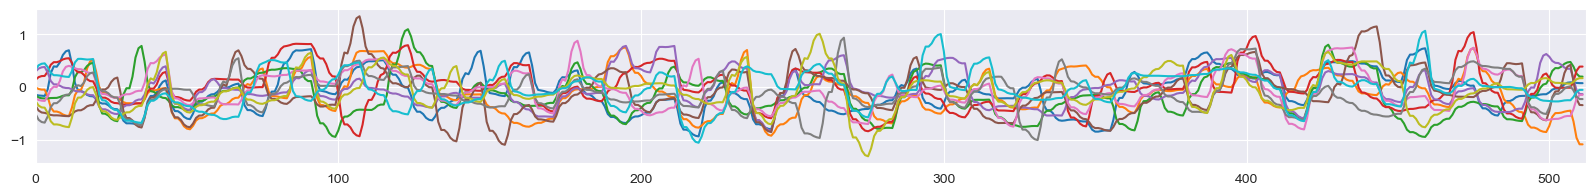

In [43]:
# 2. MODEL and Plot generated data by the model before training
latent_dim = 128
cwgan_gp = cWGAN_GP(time_dim=time_dim, feature_dim=1, latent_dim=latent_dim, n_subjects=n_subject)
x_gen = cwgan_gp.generator(keras.random.normal((len(x), latent_dim+20), mean=x.mean(), stddev=x.std())).cpu().detach()
plot_overlap(x_gen, n_seg=10, start_from=20)

Effective window size : 4.000 (s)
Effective window size : 4.000 (s)


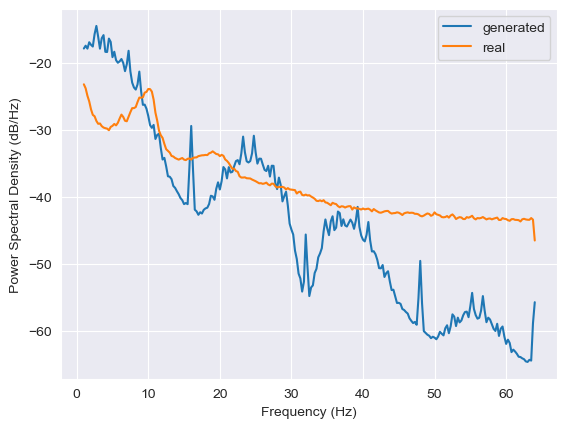

In [44]:
plot_psd(x_gen, fmin=1, fmax=200, n_fft=512, label='generated', show=False)
plot_psd(x, fmin=1, fmax=200, n_fft=512, label='real', show=True)
plt.show()

## TRAINING

In [45]:
torch.cuda.empty_cache() # clear GPU memory before training
step_loss_history = StepLossHistory()

# 3. TRAINING
cwgan_gp.compile(d_optimizer=keras.optimizers.Adam(0.0001, beta_1=0.5, beta_2=0.9),
                 g_optimizer=keras.optimizers.Adam(0.001, beta_1=0.5, beta_2=0.9),
                 gradient_penalty_weight=1.0)

In [50]:
# training
history = cwgan_gp.fit(data, epochs=10, batch_size=64, callbacks=[step_loss_history])

Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 195ms/step - d_loss: -45.1016 - g_loss: 13.9337
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - d_loss: -44.1361 - g_loss: -9.8840 
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 192ms/step - d_loss: -61.4185 - g_loss: 17.5799
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 178ms/step - d_loss: -41.0817 - g_loss: -8.3077
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 181ms/step - d_loss: -77.0611 - g_loss: 24.1303
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 184ms/step - d_loss: 58.1466 - g_loss: -60.0188
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 180ms/step - d_loss: 1284.1128 - g_loss: -1204.8400
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 181ms/step - d_loss: 1000.9407 - g_loss: -1040.0648
Epoch 9/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 181ms/step - d_loss: -1010.9749 - g_loss: 842.2616
Epoch 10/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 183ms/step - d_loss: -830.8177 - g_loss: 549.9030


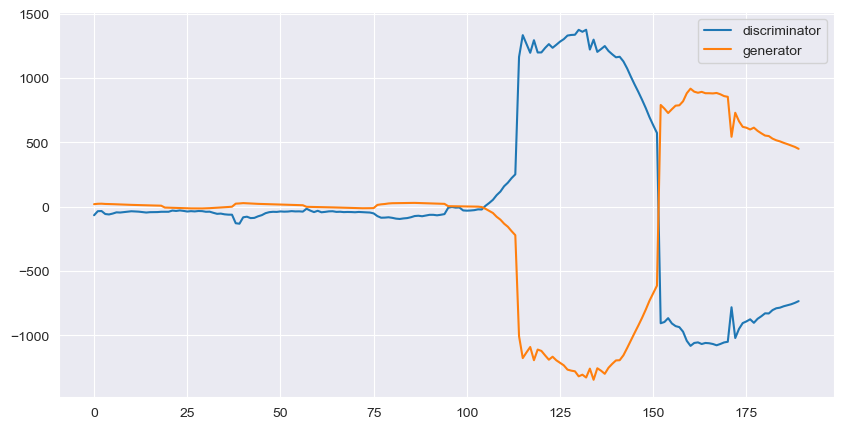

In [51]:
plot_step_losses(step_loss_history)

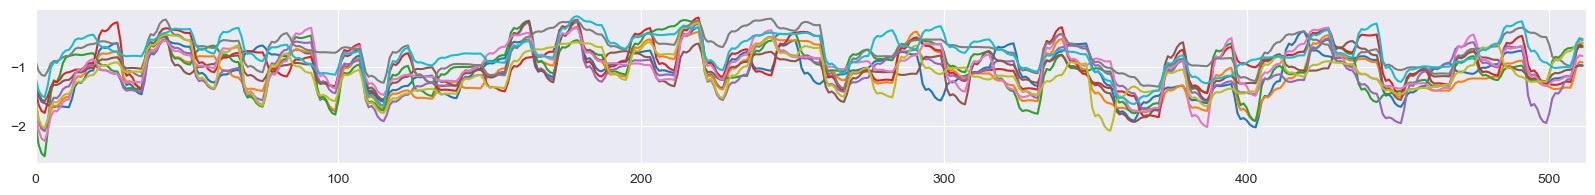

In [48]:
emb_layer = cwgan_gp.emb_layer
sub_labels = emb_layer(torch.tensor(sub, device='mps')).squeeze()
noise = keras.random.normal((len(x), latent_dim), mean=x.mean(), stddev=x.std())

# train discriminator
fake_data = cwgan_gp.generator(torch.cat((noise, sub_labels), dim=1)).detach().cpu()

plot_overlap(fake_data, n_seg=10, start_from=20)

In [49]:
real_data_labels = torch.cat((x.squeeze(), sub_labels.to(x.device)), dim=-1)
fake_data_labels = torch.cat((fake_data.squeeze(), sub_labels.to(fake_data.device)), dim=-1)
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
sigmoid(cwgan_gp.critic(fake_data_labels).mean().item()), sigmoid(cwgan_gp.critic(real_data_labels).mean().item())

(1.6504890824938036e-08, 1.0)

## DEBUG